### Import Dependencies

In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

#### Query Expansion (Parallel Execution)

In [2]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    question_relevant: bool = False
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

#### Query Expansion / Rewriting Node

In [3]:
class QueryExpandResponse(BaseModel):
   expanded_query: List[str]

In [4]:
@traceable(
    name="query_expand_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
   }

In [5]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

#### Retriever Node

In [6]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state["query"],
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context]
    }

#### Aggregator Node

In [7]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [8]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

#### User Intent Router Node

In [9]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

In [10]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def intent_router_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to clasify it into relevant or not relevant.
- If the question is not relevant, return False in field "question_relevant" and set "answer" to explanation why it is not relevant.
- If the question is relevant, return True in field "question_relevant" and set "answer" to "".
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=IntentRouterResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "question_relevant": response.question_relevant,
      "answer": response.answer
      }

In [11]:
def intent_router_conditional_edges(state: State):

    if state.question_relevant:
        return "query_expand_node"
    else:
        return "end"

#### Graph

In [12]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)
workflow.add_node("intent_router_node", intent_router_node)

workflow.add_edge(START, "intent_router_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)
workflow.add_conditional_edges(
    "intent_router_node",
    intent_router_conditional_edges,
    {
        "query_expand_node": "query_expand_node",
        "end": END
    }
)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

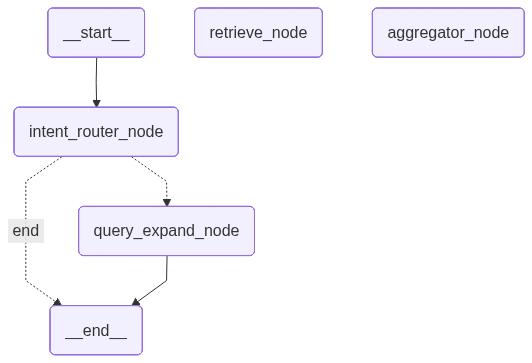

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
initial_state = {
    "initial_query": "Can I get a headset, a controller, a toy for my kid and something for my wife?"
}
result = graph.invoke(initial_state)

In [17]:
result

{'expanded_query': ['headset', 'controller', 'toy for kids', 'gift for wife'],
 'retrieved_context': ['- ID: B0B1VPZPW2, rating: 3.3, description: GAMELITE Wireless Gaming Headset Headphones with Microphone for Nintendo Switch PS5 PS4 PC Up to 40Hrs 2.4G Wireless Bluetooth RGB Gaming Headsets Over Ear Noise Canceling Mic Wired Mode for Xbox 2.4GHz Wireless, Bluetooth, 3.5mm Wired Mode. GAMELITE Wireless Gaming Headset has been applied three widely used connection methods. The 2.4G wireless mode of Wireless Gaming Headset adopts a special data channel to ensure stable connection and ultra low latency within 20ms. Wireless Gaming Headset uses the latest wireless channel, which enables your device with Bluetooth to use Wireless Gaming Headset. Wireless Gaming Headset is also equipped with the 3.5mm wired mode for you to choose Wide Platform Compatibility The Wireless Gaming Headset is compatible with Nintendo Switch, PS5, PS4, PS4 Pro Slim, Xbox series, PC, Mac, tablet, mobile phone, TV. 

In [18]:
print(result["answer"])

Yes, you can get a headset, a controller, a toy for your kid, and something for your wife from the available products. Here are some options:

1. Headset: GAMELITE Wireless Gaming Headset
- Connection: 2.4G Wireless, Bluetooth, 3.5mm Wired Mode
- Compatibility: Nintendo Switch, PS5, PS4, Xbox, PC, Mac, tablet, mobile phone, TV
- Features: Low latency wireless audio, 50mm drivers, detachable noise-canceling mic, RGB lighting, up to 40 hours usage

2. Controller: ATISTAK Wireless Game Controller for P-4 Controller
- Compatibility: P-4, P-4 pro, P-4 Slim, IOS, Android, MAC, PC, P-5 (only P-4 games)
- Features: Ergonomic design, non-slip material, improved joystick sensitivity, rechargeable battery with 8-10 hours playtime

3. Toy for your kid: NSI Toys #Boneless Super-Charged Mini Toy Stunt Skateboard
- Features: Poseable skater action figure, power-charged skateboard, controllable direction, stunt tricks

4. Something for your wife: Pink Keyboard and Mouse, Cat Ear Headset & Mouse Pad Co

In [23]:
initial_state = {
    "initial_query": "what is the weather today"
}
result = graph.invoke(initial_state)

In [24]:
result

{'retrieved_context': [],
 'question_relevant': False,
 'initial_query': 'what is the weather today',
 'answer': 'The question is about the weather today, which is not relevant to the products in stock.'}